In [0]:
import tensorflow as tf 
import numpy as np
import os
import pandas as pd
import time
from os import listdir
import functools
import pickle
import math
from IPython import display as ipythondisplay
from tqdm import tqdm

In [0]:
import subprocess
import regex as re

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay


from IPython.display import Audio
from string import Formatter





def display_model(model):
  tf.keras.utils.plot_model(model,
             to_file='tmp.png',
             show_shapes=True)
  return ipythondisplay.Image('tmp.png')


def plot_sample(x,y,vae):
    plt.figure(figsize=(2,1))
    plt.subplot(1, 2, 1)

    idx = np.where(y==1)[0][0]
    plt.imshow(x[idx])
    plt.grid(False)

    plt.subplot(1, 2, 2)
    _, _, _, recon = vae(x)
    recon = np.clip(recon, 0, 1)
    plt.imshow(recon[idx])
    plt.grid(False)

    plt.show()



class LossHistory:
  def __init__(self, smoothing_factor=0.0):
    self.alpha = smoothing_factor
    self.loss = []
  def append(self, value):
    self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
  def get(self):
    return self.loss

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()
        
cwd = os.getcwd()

def load_training_data():
    with open(os.path.join(cwd, "data", "irish.abc"), "r") as f:
        text = f.read()
    songs = extract_song_snippet(text)
    return songs

def extract_song_snippet(text):
    pattern = '\n\n(.*?)\n\n'
    search_results = re.findall(pattern, text, overlapped=True, flags=re.DOTALL)
    songs = [song for song in search_results]
    print("Found {} songs in text".format(len(songs)))
    return songs

def save_song_to_abc(song, filename="tmp"):
    save_name = "{}.abc".format(filename)
    print(save_name)
    with open(save_name, "w") as f:
        f.write(song)
    return filename

def abc2wav(abc_file):
    path_to_tool = os.path.join(cwd, 'introtodeeplearning_labs/mitdeeplearning/bin', 'abc2wav')
    cmd = "{} {}".format(path_to_tool, abc_file)
    print(cmd)
    return os.system(cmd)

def play_wav(wav_file):
    return Audio(wav_file)

def play_song(song):
    basename = save_song_to_abc(song)
    ret = abc2wav(basename+'.abc')
    print(ret)
   # if ret == 0: #did not suceed
        #return play_wav(basename+'.wav')
    return None

def play_generated_song(generated_text):
    songs = extract_song_snippet(generated_text)
    print(songs)
    if len(songs) == 0:
        print("No valid songs found in generated text. Try training the \
            model longer or increasing the amount of generated music to \
            ensure complete songs are generated!")

    for song in songs:
        play_song(song)
    print("None of the songs were valid, try training longer to improve \
        syntax.")

def test_batch_func_types(func, args):
    ret = func(*args)
    assert len(ret) == 2, "[FAIL] get_batch must return two arguments (input and label)"
    assert type(ret[0]) == np.ndarray, "[FAIL] test_batch_func_types: x is not np.array"
    assert type(ret[1]) == np.ndarray, "[FAIL] test_batch_func_types: y is not np.array"
    print("[PASS] test_batch_func_types")
    return True

def test_batch_func_shapes(func, args):
    dataset, seq_length, batch_size = args
    x, y = func(*args)
    correct = (batch_size, seq_length)
    assert x.shape == correct, "[FAIL] test_batch_func_shapes: x {} is not correct shape {}".format(x.shape, correct)
    assert y.shape == correct, "[FAIL] test_batch_func_shapes: y {} is not correct shape {}".format(y.shape, correct)
    print("[PASS] test_batch_func_shapes")
    return True

def test_batch_func_next_step(func, args):
    x, y = func(*args)
    assert (x[:,1:] == y[:,:-1]).all(), "[FAIL] test_batch_func_next_step: x_{t} must equal y_{t-1} for all t"
    print("[PASS] test_batch_func_next_step")
    return True

def test_custom_dense_layer_output(y):
    true_y = np.array([[0.2697859,  0.45750418, 0.66536945]],dtype='float32')
    assert tf.shape(y).numpy().tolist() == list(true_y.shape), "[FAIL] output is of incorrect shape. expected {} but got {}".format(true_y.shape, y.numpy().shape)
    np.testing.assert_almost_equal(y.numpy(), true_y, decimal=7, err_msg="[FAIL] output is of incorrect value. expected {} but got {}".format(y.numpy(), true_y), verbose=True)
    print("[PASS] test_custom_dense_layer_output")
    return True

In [0]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
   
  model = tf.keras.Sequential([
   
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    
   LSTM(rnn_units), 
    
    tf.keras.layers.Dense(vocab_size)
    
  ])

  return model

In [0]:
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

In [0]:
def encode_notes_full(notesArr):
    size = math.ceil(notesArr[-1:][1])
    sizeF = size*8
    mod = sizeF%120
    pad = 0
    if(mod != 0):
         pad = 120 - mod
    encodeNotes =  pd.DataFrame([[0.0]*30]*(sizeF+pad))
    length = len(notesArr)
    count = 0
    partInt=0
    for i in range(length):
        start = notesArr[0][i]
        count = 0
        end = notesArr[1][i]
        dur = float(end) - float(start)
        startInt = int(float(start))
        part = float(start) - startInt
        index = (startInt)*8
        if(part<=0.125):
            partInt = 0
        elif(0.125<part<=0.25):
            partInt = 1
        elif(0.25<part<=0.375):
            partInt = 2
        elif(0.375<part<=0.5):
            partInt = 3
        elif(0.5<part<=0.625):
            partInt = 4
        elif(0.625<part<=0.75):
            partInt = 5
        elif(0.75<part<=0.875):
            partInt = 6
        elif(0.875<part<=1.0):
            partInt = 7
        #print(partInt)
        for j in range(29):
            if(encodeNotes[j][index + partInt]==0.0 and encodeNotes[j+1][index + partInt]==0.0 and encodeNotes[j+2][index + partInt]==0.0):
                #print('here')
                encodeNotes[j][index + partInt] = dur
                encodeNotes[j+1][index + partInt] = notesArr[2][i]
                encodeNotes[j+2][index + partInt] = notesArr[3][i]
                break
    return encodeNotes
            

In [0]:
infile = open('/content/drive/My Drive/MusicData/balladArr.pkl','rb')
ballad = pickle.load(infile)
infile.close()

In [0]:
modelF = build_model(200, embedding_dim=256, rnn_units=1024, batch_size=120)

In [0]:
def get_encoded_song( songNum, instrument):
    drums = encode_notes_full(ballad[0][songNum])
    piano = encode_notes_full(ballad[1][songNum])
    guitar = encode_notes_full(ballad[2][songNum])
    bass = encode_notes_full(ballad[3][songNum])
    fullSong = pd.concat([drums, piano, guitar, bass], axis=1, sort=False)
    if(instrument=='drums'):
        zero =  pd.DataFrame([[0.0]*30]*(len(drums)))
        insSong = pd.concat([drums, zero, zero, zero], axis=1, sort=False)
    if(instrument=='piano'):
        zero =  pd.DataFrame([[0.0]*30]*(len(piano)))
        insSong = pd.concat([zero, piano, zero, zero], axis=1, sort=False)
    if(instrument=='guitar'):
        zero =  pd.DataFrame([[0.0]*30]*(len(guitar)))
        insSong = pd.concat([zero, zero, guitar, zero], axis=1, sort=False)
    if(instrument=='bass'):
        zero =  pd.DataFrame([[0.0]*30]*(len(bass)))
        insSong = pd.concat([zero, zero, zero, bass], axis=1, sort=False)
    fullSong.fillna(0.0, inplace=True)
    insSong.fillna(0.0, inplace=True)
    return fullSong, insSong
    

In [0]:
def get_batchF(encodedNotes, encodedIns1, iteration):

    idx = int(iteration * 120)
    input_batch = encodedNotes[idx:(idx+120)].values

    output_batch = encodedIns1[(idx+120):(idx+240)].values
    output_batch[output_batch > 200] = 200
    output_batch[output_batch < 0] = 0
    input_batch[input_batch > 200] = 200
    input_batch[input_batch < 0] = 0
    return input_batch, output_batch

In [0]:
num_training_iterations = 2*len(ballad)
learning_rate = 5e-3 
#genreCleaned= house
instrument = 'piano'
totalSongs = len(ballad)

checkpoint_dir = '/content/drive/My Drive/MusicData/' 
checkpoint_prefix = os.path.join(checkpoint_dir, "balladPiano")

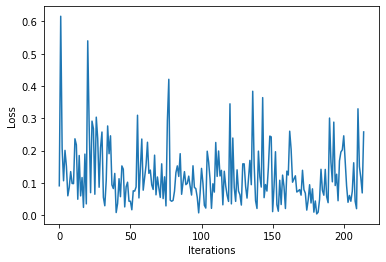

  3%|▎         | 215/6426 [1:23:40<59:15:08, 34.34s/it]

0


In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 

  with tf.GradientTape() as tape:
  
    y_hat = modelF(x) 
    
    loss = compute_loss(y, y_hat) 

 
  grads = tape.gradient(loss, modelF.trainable_variables) 
  
  optimizer.apply_gradients(zip(grads, modelF.trainable_variables))
  return loss

history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() 
for iter in tqdm(range(num_training_iterations)):
    if (iter>totalSongs):
        songNum = iter%totalSongs
    else: 
        songNum = iter
    
    song, ins = get_encoded_song( iter, instrument)
    
    for j in range(int(min((len(song)/120)-1,int((len(ins)/120)-1)))):
        print(j)
        x_batch, y_batch = get_batchF(song, ins, j)
        loss = train_step(x_batch, y_batch)
        
    history.append(loss.numpy().mean())
    plotter.plot(history)

    if(iter % 100 == 0):     
            print('Saved')
            modelF.save_weights(checkpoint_prefix)
    

modelF.save_weights(checkpoint_prefix)

In [0]:
'''Questions about our approach

Explanation of method - RNN: 

As previously discussed out choice of an RNN network was well fitted to the task as we've been able ot achieve relatively low loss 
across mutiple genres (only one present in this notebook).
We are currently using sparse categorical cross entropy as our loss function and setting the model parameters to 1024 rnn units and 256 nodes in the embedding layer

Changes from previous:

We strongly adjusted the encoding method from the previous iteration to include more seperation of notes by inception time (8 instead of 4 buckets per second) and more notes at each time step 
to account for genres like house that have many overlapping notes. However, this makes the note representation quite sparse which is an issue as it artificially inflated loss because so many values are zero.
We are looing in to adjusting the loss function and test batch to correct this, and looking into changing the encoding a bit as well. 

Discussion of Results:

We are still training many of the models (they take quite a while to train and it also was slow to pass the note data through our pipelines as well). However our preliminary findings indicate there is 
not a susbtantial difference in the ability to learn the genres based on their loss rates. This coould change as we modify the loss/ encoding as described above, but as a preliminary finding is 
a solid answer in regards to our research question. We will procede to analyze if there is any difference in the type of features that are learned even if the loss rate is similar. 

